Importing libraries

In [ ]:
!pip install -U gensim
!pip install -U nltk
!python -m nltk.downloader punkt #This tokenizer divides a text into a list of sentences, by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.
!python -m nltk.downloader stopwords

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)
Requirement already up-to-date: nltk in /usr/local/lib/python3.7/dist-packages (3.5)
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install keras

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

reading data

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_ans_eval/training_set_rel3 - training_set_rel3.csv")
y=data['domain1_score']
X=data.dropna(axis=1)#remove missing values
X=X.drop(columns=['rater1_domain1','rater2_domain1'])#remove unnecessary docs.

In [ ]:
y.describe()

count    12976.000000
mean         6.800247
std          8.970705
min          0.000000
25%          2.000000
50%          3.000000
75%          8.000000
max         60.000000
Name: domain1_score, dtype: float64

Preprocessing

In [ ]:
import spacy
from spacy import attrs
from spacy.language import Language
from spacy.symbols import NOUN, PROPN, VERB
from spacy.tokens import Doc, Span, Token
nlp=spacy.load('en_core_web_sm')
constants_={
    'PERSON':['@PERSON',0],
    'ORG': ['@ORGANIZATION',0],
    'GPE': ['@LOCATION',0],
    'MONEY':['@MONEY',0],
    'TIME':['@TIME',0],
    'DATE':['@DATE',0],
    'PERCENT':['@PERCENT',0]
}
def preprocess(inp,ner_dict):
  c=1
  essay=nlp(inp)
  for entity in essay.ents:
    if entity.text in ner_dict.keys():
      continue
    if entity.label_ in constants_.keys():
      x=constants_[entity.label_][1]+1
      constants_[entity.label_][1]=x
      ner_dict[entity.text]=constants_[entity.label_][0]+str(x)
    else:
      ner_dict[entity.text]='@Caps'+str(c)
      c+=1
  s=''
  for i in ner_dict.keys():
    inp=inp.replace(i,ner_dict[i],1)
  return inp
  

In [ ]:
preprocess('''Apple Inc. is an American multinational technology company headquartered in Cupertino, California, that designs, develops and sells consumer electronics, computer software, and online services. It is considered one of the Big Tech technology companies, alongside Amazon, Google, Microsoft, and Facebook. The company's hardware products include the iPhone smartphone, the iPad tablet computer, the Mac personal computer, the iPod portable media player, the Apple Watch smartwatch, the Apple TV digital media player, the AirPods wireless earbuds and the HomePod smart speaker. Apple's software includes macOS, iOS, iPadOS, watchOS, and tvOS operating systems, the iTunes media player, the Safari web browser, the Shazam music identifier and the iLife and iWork creativity and productivity suites, as well as professional applications like Final Cut Pro, Logic Pro, and Xcode. ''',{})

["@ORGANIZATION1 is an @Caps1 multinational technology company headquartered in @LOCATION1, @LOCATION2, that designs, develops and sells consumer electronics, computer software, and online services. It is considered @Caps2 of the @ORGANIZATION2 technology companies, alongside @ORGANIZATION3, @ORGANIZATION4, @ORGANIZATION5, and @ORGANIZATION6. The company's hardware products include the @ORGANIZATION7 smartphone, the iPad tablet computer, the @ORGANIZATION8 personal computer, the iPod portable media player, the @ORGANIZATION9 smartwatch, the @ORGANIZATION10 TV digital media player, the @ORGANIZATION11 wireless earbuds and the @ORGANIZATION12 smart speaker. Apple's software includes @ORGANIZATION13, @LOCATION3, @ORGANIZATION14, and @PERSON1 operating systems, the @LOCATION4 media player, the @LOCATION5 web browser, the @Caps3 music identifier and the @Caps4 and @ORGANIZATION15 creativity and productivity suites, as well as professional applications like @Caps5, Logic Pro, and @ORGANIZATI

In [ ]:
def getWordListfromEssay(essay,stopwords_):
  essay=re.sub("[^a-zA-Z]"," ",essay) #removes special chars
  words=essay.lower().split()
  if stopwords_:
    s=set(stopwords.words("english")) # a set of all stopwords in english
    words=[i for i in words if i not in s]
  return words #a list of words with stopwords removed

In [ ]:
# getWordListfromEssay('This was mossad 101',False) #sample list of sentences

In [ ]:
def getSentencefromEssay(essay,stopwords_):
  tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')
  s=tokenizer.tokenize(essay.strip()) #tokenizes sentences from essay
  sent_list=[]
  for sent in s:
    if len(sent)>0:
      sent_list.append(getWordListfromEssay(sent,stopwords_))
  return sent_list

In [ ]:
def getFeatureVector(words,model,num_features):
  feat_vec=np.zeros((num_features,),dtype="float32")
  n=0
  index2word_set=set(model.wv.index2word)
  for word in words:
    if word in index2word_set:
      n+=1
      feat_vec=np.add(feat_vec,model[word])
  feat_vec=np.divide(feat_vec,n)
  return feat_vec

In [ ]:
def getAvgVec(essay,model,num_features):
  c=0
  essay_vec=np.zeros((len(essay),num_features),dtype="float32")
  for i in essay:
    essay_vec[c]=getFeatureVector(i,model,num_features)
    c+=1
  return essay_vec

sample LSTM

In [ ]:
from keras.layers import LSTM,Embedding,Dense,Dropout,Flatten
from keras.models import Sequential,load_model,model_from_config

def getModel():
  model=Sequential() #since we are dealing with sequential data (text)
  # #LSTM with 2 layers
  # model.add(LSTM(300,dropout=0.4,recurrent_dropout=0.4,input_shape=[1,300],return_sequences=True))
  # model.add(LSTM(64, recurrent_dropout=0.4))
  # model.add(Dropout(0.5))#prevents from overfitting
  # model.add(Dense(1,activation='relu'))#provides learning features from all combinations
  # #dense layer is stacked after LSTM because: Many frameworks just give you the internal state  h  as output, so the dimensionality of this output is equals to the number of unit, which is propably not the dimensionality of your desired target.
  model.add(LSTM(300,input_shape=[1,300],return_sequences=True))
  model.add(LSTM(64))
  model.add(Dropout(0.2))#prevents from overfitting
  model.add(Dense(1,activation='relu'))#provides learning features from all combinations
  model.compile(loss='mean_squared_error',optimizer='rmsprop',metrics=['mae'])
  # #rmsprop: We always keep a moving average over the root mean squared (hence Rms) gradients, by which we divide the current gradient.
  model.summary()
  return model

In [ ]:
from sklearn.model_selection import train_test_split
X, X_TEST, y, Y_TEST=train_test_split(X,y,test_size=0.2,random_state=0,shuffle=True)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

kf=KFold(n_splits=5,shuffle=True)
results=[]
y_pred_list=[]
count=1
for trainkf,validkf in kf.split(X):
  print("\n---------Fold{}----------\n".format(count))
  X_valid,X_train,y_valid,y_train=X.iloc[validkf],X.iloc[trainkf],y.iloc[validkf],y.iloc[trainkf]
  train_essays=X_train['essay']
  valid_essays=X_valid['essay']
  sentences=[]
  for essay in train_essays:
    sentences+=getSentencefromEssay(essay,True)
  num_features=300
  min_word_count=40
  num_workers=4
  context=10
  downsampling=1e-3
  print("Training Word2Vec Model...")
  model=Word2Vec(sentences,workers=num_workers,size=num_features,min_count=min_word_count,window=context,sample=downsampling)
  model.init_sims(replace=True)
  model.wv.save_word2vec_format('word2vecmodel.bin',binary=True)
  clean_train_essays=[]
  for essay_v in train_essays: 
    clean_train_essays.append(getWordListfromEssay(essay_v,True))
  trainDataVecs=getAvgVec(clean_train_essays,model,num_features)
  clean_valid_essays=[]
  for essay_v in valid_essays:
    clean_valid_essays.append(getWordListfromEssay(essay_v,True))
  validDataVecs=getAvgVec(clean_valid_essays,model,num_features)#essay representations in 300 dimensions
  trainDataVecs=np.array(trainDataVecs)
  validDataVecs=np.array(validDataVecs)
  trainDataVecs=np.reshape(trainDataVecs,(trainDataVecs.shape[0],1,trainDataVecs.shape[1]))#[[x1,x2...xn]] becomes[[[x1,x2,...xn]]]
  validDataVecs=np.reshape(validDataVecs,(validDataVecs.shape[0],1,validDataVecs.shape[1]))
  lstm_model=getModel()
  lstm_model.fit(trainDataVecs,y_train,batch_size=64,epochs=50)#since batch size is 64, 2nd lstm layer ouputs a vector of size 64, 64 values for 62 rows of the dataset!
  y_pred=lstm_model.predict(validDataVecs)
  if count==5:
    lstm_model.save('./model_weights/final_lstm.h5')
  y_pred=np.around(y_pred)
  result=cohen_kappa_score(y_valid.values,y_pred,weights='quadratic')
  print("Kappa Score: {}".format(result))
  results.append(result)
  count+=1



---------Fold1----------

Training Word2Vec Model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
130/130 [==============================] - 5s 15ms/step - loss: 86.0707 - mae: 4.9915
Epoch 2/50
130/130 [==============================] - 2s 15ms/step - loss: 41.8336 - mae: 3.4884
Epoch 3/50
130/130 [==============================] 

Testing the model

In [ ]:
def predictor(test_essays,model,lstm_model):
  clean_test_essays=[]
  # test_essays=X_TEST['essay']
  for essay_v in test_essays:
    clean_test_essays.append(getWordListfromEssay(essay_v,True))
  testDataVecs=getAvgVec(clean_test_essays,model,num_features)
  testDataVecs=np.array(testDataVecs)
  testDataVecs=np.reshape(testDataVecs,(testDataVecs.shape[0],1,testDataVecs.shape[1]))
  y_pred=lstm_model.predict(testDataVecs)
  y_pred=np.around(y_pred)
  # y_pred=y_pred.ravel()
  return y_pred

In [ ]:
y_pred=predictor(list(X_TEST['essay']),model,lstm_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


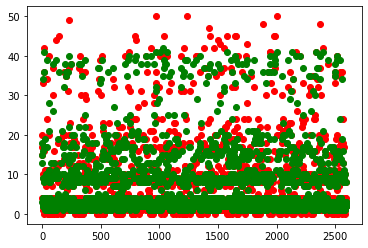

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(range(2596),Y_TEST.values,c='r')
plt.scatter(range(2596),y_pred.ravel(),c='g')
plt.show()

In [ ]:
cohen_kappa_score(Y_TEST.values,y_pred,weights='quadratic')

0.9615009500505286

In [ ]:
def getWeightForKeyword(inp,keywords):
  c=0
  for i in keywords:
    if i in inp:
      print(i)
      c+=1
  return c/len(keywords)

In [ ]:
inp=input()
'''Apple Inc. is an American multinational technology company headquartered in Cupertino, California, that designs, develops and sells consumer electronics, 
computer software, and online services. It is considered one of the Big Tech technology companies, alongside Amazon, Google, Microsoft, and Facebook. 
The company's hardware products include the iPhone smartphone, the iPad tablet computer, the Mac personal computer, the iPod portable media player, the Apple Watch 
smartwatch, the Apple TV digital media player, the AirPods wireless earbuds and the HomePod smart speaker. Apple's software includes macOS, iOS, iPadOS, watchOS, and 
tvOS operating systems, the iTunes media player, the Safari web browser, the Shazam music identifier and the iLife and iWork creativity and productivity suites, 
as well as professional applications like Final Cut Pro, Logic Pro, and Xcode. '''


'''Elon Reeve Musk was born in 1971. He is a business magnate, industrial designer, and engineer. He is the founder, CEO, CTO, and chief designer of SpaceX, 
early investor, CEO, and product architect of Tesla, Inc. He is also the founder of The Boring Company; co-founder of Neuralink; and co-founder and initial 
co-chairman of OpenAI. A centibillionaire, Musk is one of the richest people in the world. Musk was born to a Canadian mother and South African father. 
He was raised in Pretoria, South Africa. He briefly attended the University of Pretoria. He later moved to Canada aged 17. He then attended Queen's University. 
He transferred to the University of Pennsylvania two years later. He received dual bachelor's degrees in economics and physics there. He moved to California in 
1995 for Stanford University. But he decided instead to pursue a business career. He then co-founded the web software company Zip2 with his brother Kimbal. 
The startup was acquired by Compaq for $307 million in 1999. Musk co-founded online bank X.com that same year. It merged with Confinity in 2000.  This later 
formed the company PayPal, PayPal was subsequently bought by eBay in 2002 for $1.5 billion.'''

ner_dict={}
keywords=['Apple','company','technology','Steve','Jobs','America','electronics','software']
weight=getWeightForKeyword(inp,keywords)
inp=preprocess(inp,ner_dict)
y_pred=predictor(list(X_TEST['essay'])+[inp],model,lstm_model)
print("Score: ",y_pred[-1]*weight)

Elon Reeve Musk was born in 1971. He is a business magnate, industrial designer, and engineer. He is the founder, CEO, CTO, and chief designer of SpaceX,  early investor, CEO, and product architect of Tesla, Inc. He is also the founder of The Boring Company; co-founder of Neuralink; and co-founder and initial  co-chairman of OpenAI. A centibillionaire, Musk is one of the richest people in the world. Musk was born to a Canadian mother and South African father.  He was raised in Pretoria, South Africa. He briefly attended the University of Pretoria. He later moved to Canada aged 17. He then attended Queen's University.  He transferred to the University of Pennsylvania two years later. He received dual bachelor's degrees in economics and physics there. He moved to California in  1995 for Stanford University. But he decided instead to pursue a business career. He then co-founded the web software company Zip2 with his brother Kimbal.  The startup was acquired by Compaq for $307 million in 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Score:  [2.5]


In [ ]:
getWeightForKeyword(inp,keywords)

Apple
company
technology
electronics
software


0.625

In [ ]:
ner_dict

{'AirPods': '@ORGANIZATION27',
 'Amazon': '@ORGANIZATION19',
 'American': '@Caps1',
 'Apple': '@ORGANIZATION26',
 'Apple Inc.': '@ORGANIZATION17',
 'Big Tech': '@ORGANIZATION18',
 'California': '@LOCATION7',
 'Cupertino': '@LOCATION6',
 'Facebook': '@ORGANIZATION22',
 'Final Cut Pro': '@Caps5',
 'Google': '@ORGANIZATION20',
 'HomePod': '@ORGANIZATION28',
 'Mac': '@ORGANIZATION24',
 'Microsoft': '@ORGANIZATION21',
 'Safari': '@LOCATION10',
 'Shazam': '@Caps3',
 'Xcode': '@ORGANIZATION32',
 'iLife': '@Caps4',
 'iOS': '@LOCATION8',
 'iPadOS, watchOS': '@ORGANIZATION30',
 'iPhone': '@ORGANIZATION23',
 'iTunes': '@LOCATION9',
 'iWork': '@ORGANIZATION31',
 'macOS': '@ORGANIZATION29',
 'one': '@Caps2',
 'the Apple Watch': '@ORGANIZATION25',
 'tvOS': '@PERSON2'}

array([nan], dtype=float32)

In [ ]:
# print("Training Word2Vec model...")
# model=Word2Vec(sentences,workers=num_workers,size=num_features,min_count=min_word_count,window=contenxt,sample=downsampling)
# model.init_sims(replace=True)
# mode.wv.save_word2Vec_format('word2vecmodel.bin',binary=True)

Training Word2Vec model...


NameError: ignored